# Girvan-Newman Partitioning

The purpose of this homework is 
- to share some examples for how to visualize graphs that have nodes split into partitions
- to demonstrate how to use the betweenness measures in `Networkx`
- to demonstrate how to relate the modularity metric to visualizations of graph partitions
- give examples for how the Girvan-Newman partitioning algorithm works
- to demonstrate how to use the modularity metric to find a good partition
- to practice using dendrograms to understand partioning

The tutorial will use the karate class graph to demonstrate different steps in the process, and the homework will ask you to apply these steps to a few different graphs. The homework will also ask you to interpret what you are seeing for the different graphs.

---

# Utilities

We'll start by defining some utilities for showing graphs and partitions. Sorry that I haven't had time to split these into a separate utility file.

In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from typing import Tuple, Hashable, Union, Literal
from numpy import linalg as linalg
from matplotlib.axes import Axes

####################################
## Create datatype that specifies ##
## the style of the graph display ##
####################################
PlotType = Literal[
    "GRAPHVIZ",
    "CIRCULAR",
    "SPRING",
    "DOT"
]

#################################
## Show graph with node labels ##
## in a chosen set of axes     ##
#################################
def show_graph(G: nx.Graph,
               title: str = "",
               labels: Union[dict[int, str], None] = None,
               axes: Union[None, Axes] = None,
               node_color: Union[None, list[str]] = None,
               plot_style: PlotType = "GRAPHVIZ"
               ) -> dict[Hashable, Tuple[float, float]]:
    if labels is None:
        labels = {node: str(node) for node in G.nodes()}
    if axes is None:
        plt.figure(figsize=(4,4))
        axes: Axes = plt.gca()
    if node_color is None:
        node_color = ['y' for _ in G.nodes]
    node_positions: dict[Hashable, tuple[float, float]] = dict()
    if plot_style == "GRAPHVIZ":
        node_positions = nx.nx_pydot.graphviz_layout(G,prog='neato')
    elif plot_style == "DOT":
        node_positions = nx.nx_pydot.graphviz_layout(G,prog='dot')
    elif plot_style == "SPRING":
        node_positions = nx.spring_layout(G)
    else:
        node_positions = nx.circular_layout(G)

    nx.draw(G, 
        node_positions, 
        node_color = node_color, 
        with_labels = True, 
        labels = labels,
        node_size = 300,
        ax=axes, 
        alpha=0.8)
    
    axes.set_title(title)
    axes.set_aspect('equal')

    # Return the node positions in case I want to use them again
    return node_positions

def get_NCM_Figure3_14():
    G = nx.Graph()
    G.add_nodes_from(range(0,14))
    G.add_edges_from([(0,1),(0,2),(1,2),(3,4),(3,5),(4,5),(8,9),(8,10),(9,10),(11,12),(11,13),(12,13),(2,6),(5,6),(7,8),(7,11),(6,7)])
    pos = nx.spring_layout(G)
    return G, pos

def draw_edge_by_type(G, pos, edge, partition):
    edge_style = 'dashed'
    for part in partition:
        if edge[0] in part and edge[1] in part:
            edge_style = 'solid'
            break
    nx.draw_networkx_edges(G, pos, edgelist=[edge], style = edge_style)

def show_partitions(G, partition_list, pos = None):
    color_list = ['c','m','y','g','r']
    plt.figure()
    plt.axis('off')
    if pos is None: pos = nx.spring_layout(G, seed = 10)
    for i in range(len(partition_list)):
        nx.draw_networkx_nodes(partition_list[i],pos,node_color=color_list[i%len(color_list)], alpha = 0.8)
    for edge in G.edges:
        draw_edge_by_type(G, pos, edge, partition_list)
    nx.draw_networkx_labels(G,pos)
    if len(G.edges) == 0:
        mod = 0
    else:
        mod = nx.algorithms.community.quality.modularity(G,partition_list)
    title = "Modularity = " + str(np.round(mod,2))
    plt.title(title)


## Example Graph

Show the karate class network

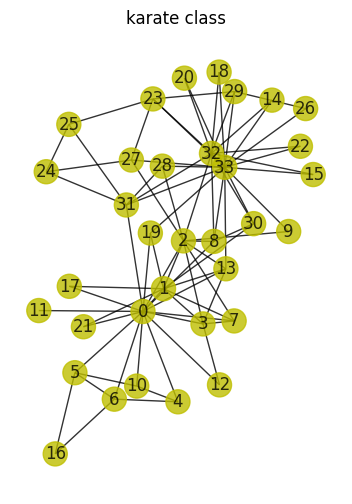

In [11]:
karate_class: nx.Graph = nx.karate_club_graph()
_ = plt.figure(figsize=(6,6))
axes = plt.gca()
_ = show_graph(karate_class, title = "karate class", axes = axes)

## Visualizing a Partition

Let's create a couple of different partitions of the vertices into groups. Start with a partition that has two groups. A partition of the vertex set splits the vertex set $V$ into a collection subsets or groups {$S_1, S_2, \ldots, S_L$} such that
- $V = S_1 \cup S_2 \cup \ldots \cup S_L$: the union of the groups is the set of vertices
- $\forall i, j$ such that $i\neq j$ satisfies $S_i\cap S_j\neq \empty$: groups don't overlap
- $\forall i S_i\neq \emptyset$: no group can be empty.

Let's start with two groups in the partition. We use a list of groups since that was convenient.

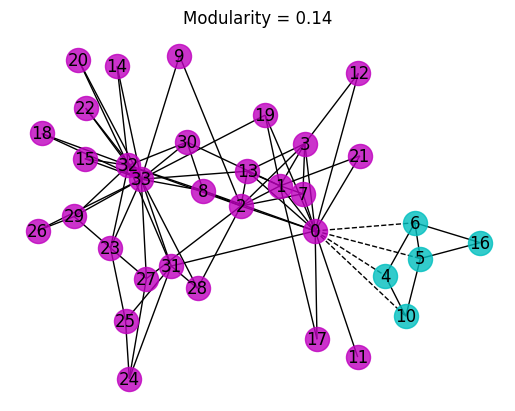

In [3]:
partitions = [set([4,5,6,10,16]), set(karate_class.nodes()) - set([4,5,6,10,16])]
show_partitions(karate_class, partitions)

Let's repeat but with three groups in the partition.

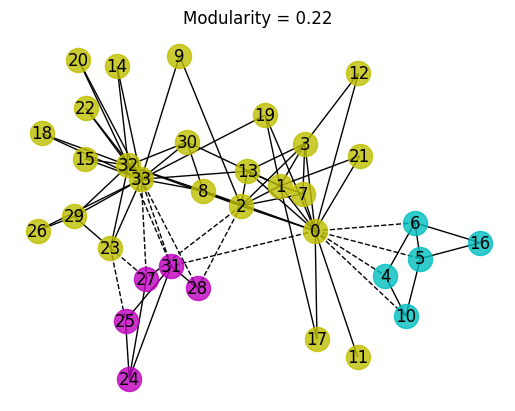

In [4]:
group1 = set([4,5,6,10,16])
group2 = set([24,25,27,28,31])
group3 = set(karate_class.nodes()) - group1 - group2
partitions = [group1, group2, group3]
show_partitions(karate_class, partitions)

---

## Betweenness

**Edge betweenness** represents the idea of a bridge or local bridge. It also represents the idea of which edges are most central to a network. There are many measures of edge betweenness, but we are only discussing the measure created by Girvan and Newman, which we discussed in class. We used a graph in class to illustrate edge betweenness, so let's show the edge betweenness scores for this graph.

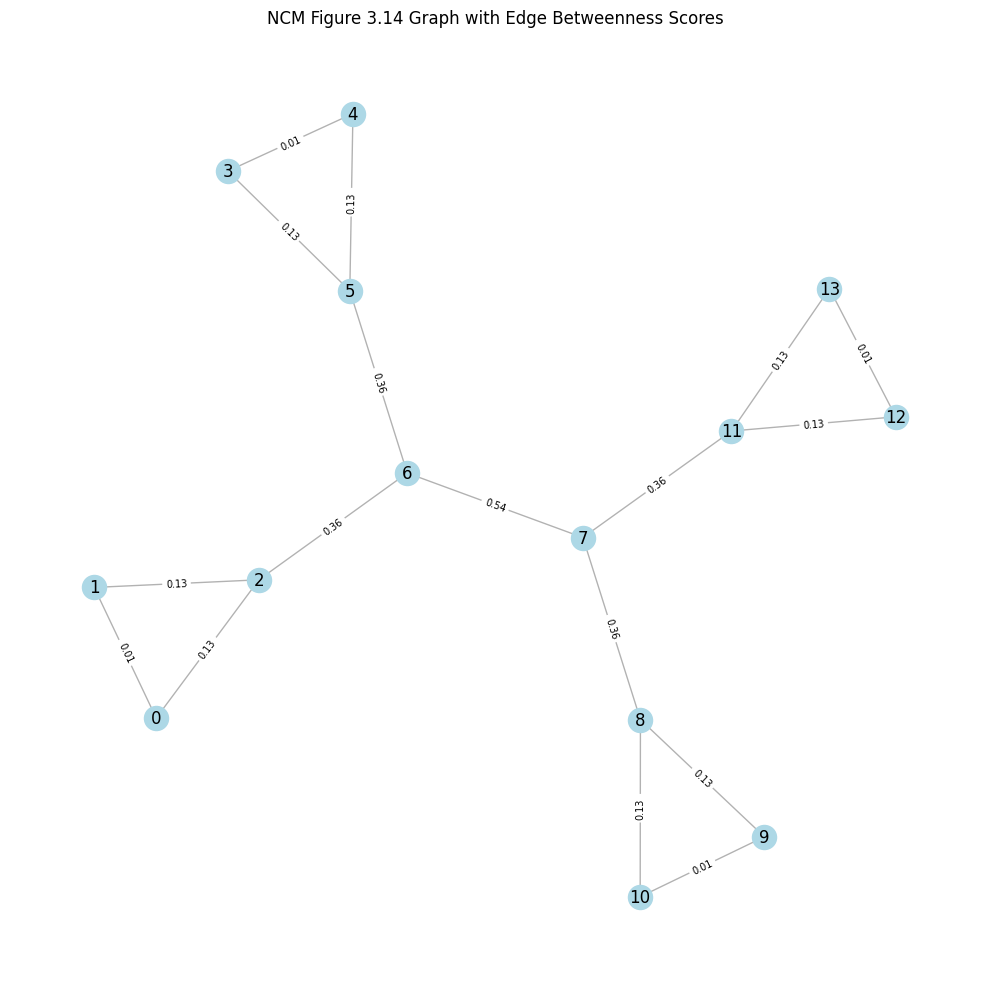

In [3]:
# Edge betweenness scores for the edges
from networkx import edge_betweenness_centrality as betweenness

G, pos = get_NCM_Figure3_14()
edge_scores = betweenness(G)
pos = nx.nx_pydot.graphviz_layout(G, prog='neato')

# Create a figure and show the graph
fig, ax = plt.subplots(figsize=(10, 10))

# Draw the graph
nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=300, ax=ax)
nx.draw_networkx_labels(G, pos, ax=ax)
nx.draw_networkx_edges(G, pos, ax=ax, alpha=0.3)

# Label edges with their betweenness scores (rounded to 2 decimal places)
edge_labels = {edge: f"{score:.2f}" for edge, score in edge_scores.items()}
nx.draw_networkx_edge_labels(G, pos, edge_labels, ax=ax, font_size=7)

ax.set_title("NCM Figure 3.14 Graph with Edge Betweenness Scores")
ax.axis('off')
plt.tight_layout()
plt.show()

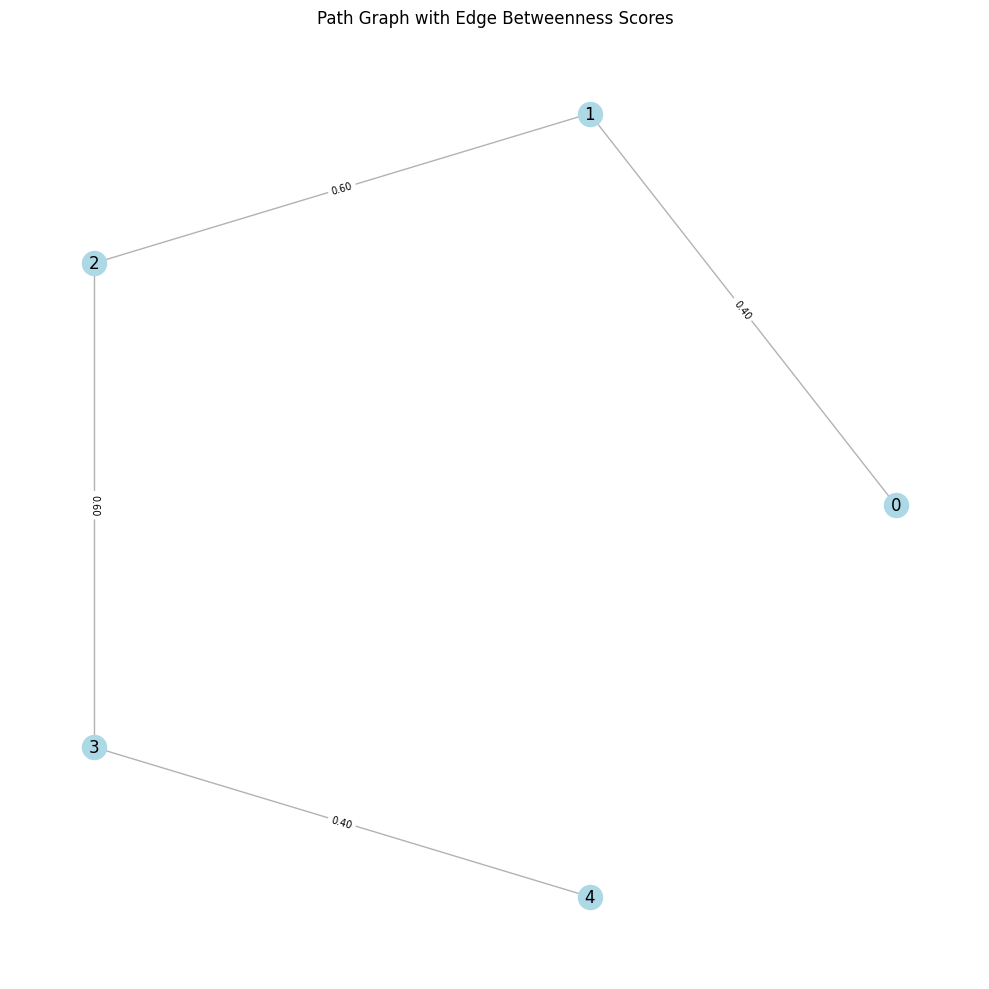

In [4]:
G = nx.path_graph(5)  

edge_scores = betweenness(G)
pos = nx.circular_layout(G)

# Create a figure and show the graph
fig, ax = plt.subplots(figsize=(10, 10))

# Draw the graph
nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=300, ax=ax)
nx.draw_networkx_labels(G, pos, ax=ax)
nx.draw_networkx_edges(G, pos, ax=ax, alpha=0.3)

# Label edges with their betweenness scores (rounded to 2 decimal places)
edge_labels = {edge: f"{score:.2f}" for edge, score in edge_scores.items()}
nx.draw_networkx_edge_labels(G, pos, edge_labels, ax=ax, font_size=7)

ax.set_title("Path Graph with Edge Betweenness Scores")
ax.axis('off')
plt.tight_layout()
plt.show()


---

## Girvan-Newman partitioning

The Girvan-Newman partitioning algorithm greedily removes the edge with highest _edge betweenness_. The algorithm stops when a partition with maximum modularity is found (with reasonable confidence). 

We'll use the `nx.girvan_newman` to find all possible communities which can be obtained by greedily removing the edge with highes edge betweenness. See [girvan_newman](!https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.centrality.girvan_newman.html).

In [12]:
from typing import Iterator, Tuple
partitions: Iterator = nx.community.girvan_newman(karate_class)
partition_list: list[Tuple[set, ]] = list(partitions)
print(partition_list)
for communities in partition_list:
    print(tuple(sorted(c) for c in communities))

[({0, 1, 3, 4, 5, 6, 7, 10, 11, 12, 13, 16, 17, 19, 21}, {2, 8, 9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33}), ({0, 1, 3, 4, 5, 6, 7, 10, 11, 12, 13, 16, 17, 19, 21}, {32, 33, 2, 8, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31}, {9}), ({0, 1, 3, 7, 11, 12, 13, 17, 19, 21}, {32, 33, 2, 8, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31}, {4, 5, 6, 10, 16}, {9}), ({0, 1, 3, 7, 11, 12, 13, 17, 19, 21}, {2, 24, 25, 27, 28, 31}, {4, 5, 6, 10, 16}, {32, 33, 8, 14, 15, 18, 20, 22, 23, 26, 29, 30}, {9}), ({0, 1, 3, 7, 12, 13, 17, 19, 21}, {2, 24, 25, 27, 28, 31}, {4, 5, 6, 10, 16}, {32, 33, 8, 14, 15, 18, 20, 22, 23, 26, 29, 30}, {9}, {11}), ({0, 1, 3, 7, 12, 13, 17, 19, 21}, {2, 24, 25, 27, 28, 31}, {4, 5, 6, 10, 16}, {32, 33, 8, 14, 15, 18, 20, 22, 23, 29, 30}, {9}, {11}, {26}), ({0, 1, 3, 7, 13, 17, 19, 21}, {2, 24, 25, 27, 28, 31}, {4, 5, 6, 10, 16}, {32, 33, 8, 14, 15, 18, 20, 22, 23, 29, 30}, {9}, {11}, {12}, {26}), ({0, 1, 3, 7, 13, 17, 19, 21}, {2

Each line above represents a different possible partitioning of the vertices into groups. The first line partitions vertices into two groups, the second line into three groups, and the last line into one-group-per vertex.

---

Let's take a peak at the first partition. We'll display the groups by separating vertices into different colors, with all the vertices in a single group assigned the same color. 

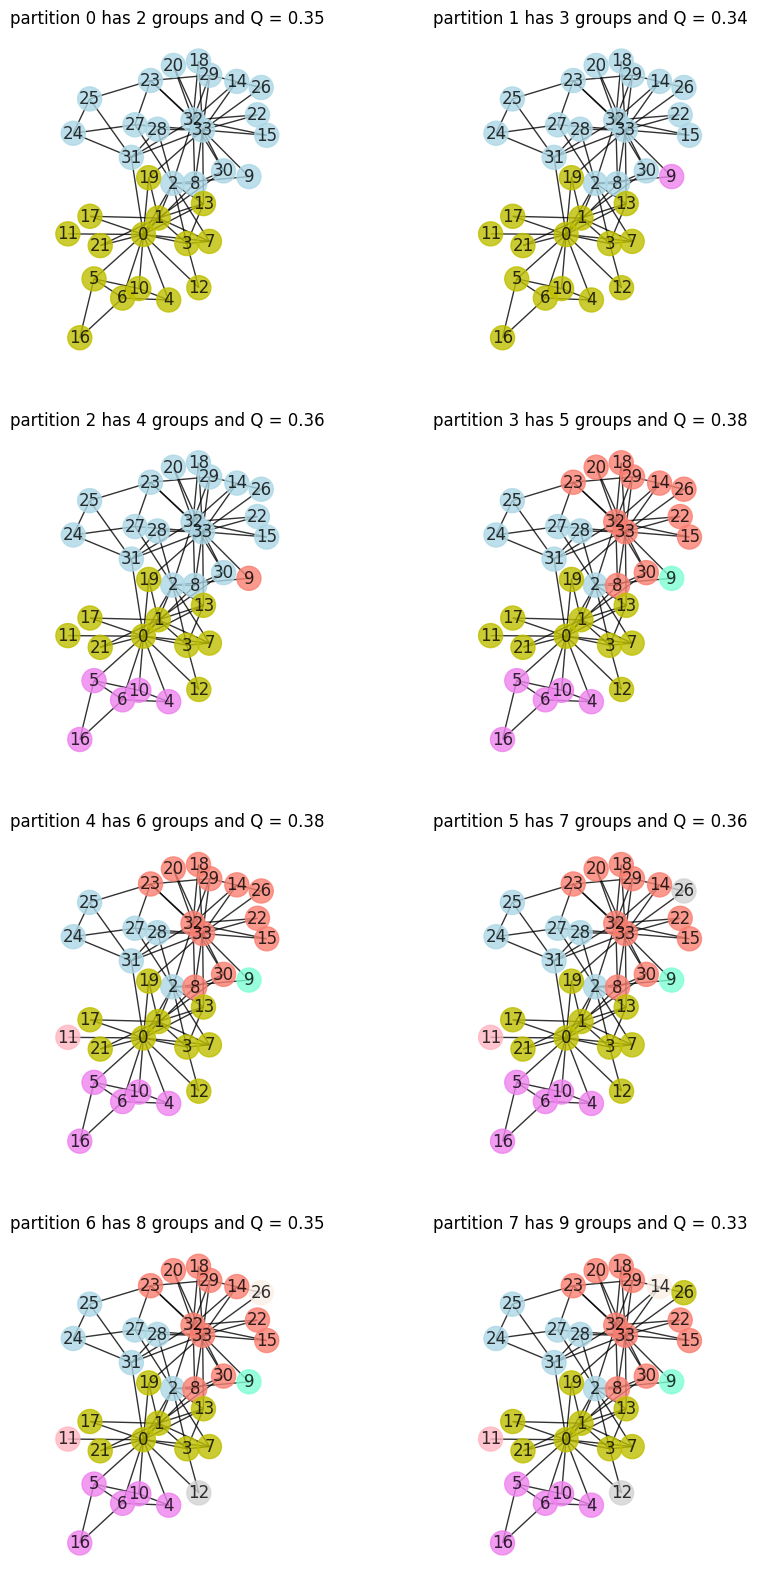

In [62]:
colors: list[str] = ['y', 'lightblue', 'violet', 'salmon', 
                         'aquamarine', 'lightpink', 'lightgray', 'linen']

_, axes = plt.subplots(nrows=4, ncols=2, figsize=(10, 20))
for i in range(8): # Iterate through the first four groups
    node_group_dict: dict[int, int] = {node: 0 for node in sorted(karate_class.nodes())}
    for group_num in range(len(partition_list[i])):
        for node in partition_list[i][group_num]:
            node_group_dict[node] = group_num
    
    node_colors = [colors[node_group_dict[node]%len(colors)] for node in karate_class.nodes()]
    title: str = f"partition {i} "
    title = title + f"has {len(partition_list[i])} groups "
    title = title + f"and Q = {np.round(nx.community.modularity(karate_class, partition_list[i]),2)}"
    _ = show_graph(karate_class, 
                   node_color=node_colors, 
                   axes=axes[int(np.floor(i/2)), i%2],
                   title = title)

Observe two things about the plots
1. The change in modularity isn't simple. It starts at a value, goes down, and then goes back up.
2. Node 9 is put into its own group as soon as three groups are possible. That probably doesn't match your intuition, but it is correct given the greedy way that the Girvan-Newman partitioning algorithm handles edge betweenness.

---

#### Finding the partition with maximum modularity

If we search through each possible way that the graph can be partitioned into communities by the Girvan-Newman algoirthm, we can find the partition that maximizes modularity. Let's plot modularity as a function of the partition.

Text(0.5, 1.0, 'Modularity as a function of partition')

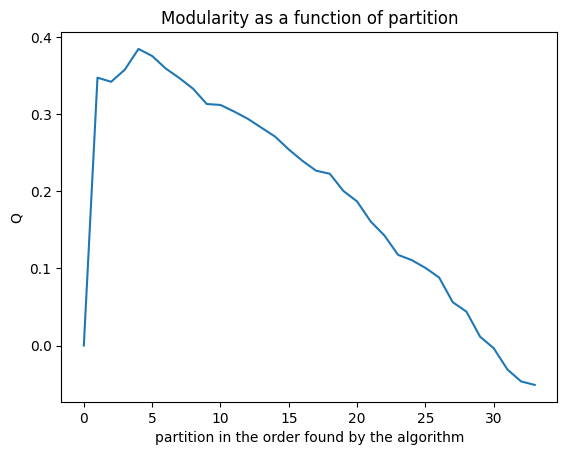

In [63]:
Q: list[float] = []
Q.append(nx.community.modularity(karate_class, (set(karate_class.nodes()),{}))) # Modularity of no partitions
for partition in partition_list:
    Q.append(nx.community.modularity(karate_class, partition))
_ = plt.plot(Q)
plt.xlabel('partition in the order found by the algorithm')
plt.ylabel('Q')
plt.title('Modularity as a function of partition')

Find the best partition

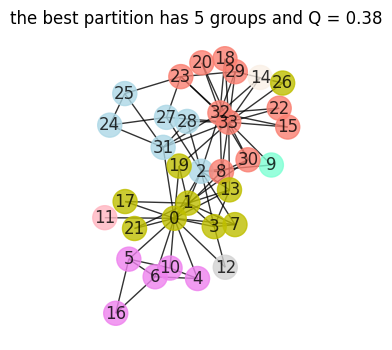

In [64]:
best_partition = max(partition_list, 
                     key=lambda partition: nx.community.modularity(karate_class, partition))

# Calculate the maximum Q value for reference
max_Q = nx.community.modularity(karate_class, best_partition)

node_group_dict: dict[int, int] = {node: 0 for node in sorted(karate_class.nodes())}
for group_num in range(len(partition_list[i])):
    for node in partition_list[i][group_num]:
        node_group_dict[node] = group_num

node_colors = [colors[node_group_dict[node]%len(colors)] for node in karate_class.nodes()]
title: str = f"the best partition has {len(best_partition)} groups "
title = title + f"and Q = {np.round(max_Q,2)}"
_ = show_graph(karate_class, 
                node_color=node_colors, 
                title = title)

---
---

## Dendrogram

A dendrogram is a visualization tool that can provide insight into clustering. In the context of finding interesting communities in a network using the Girvan-Newman method, we are doing a form of clustering where we _divide_ the network into possible partitions and then select which partition we like most. 

The [tutorial found here](!https://www.data-to-viz.com/graph/dendrogram.html) provides a nice introduction to dendrograms.

---

Let's introduce the dendrogram in the context of a very simple graph.

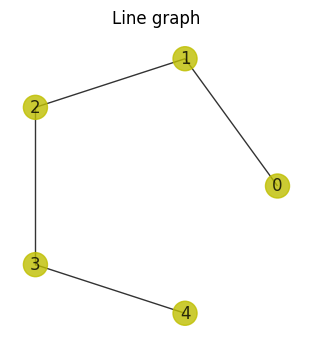

In [65]:
G: nx.Graph = nx.path_graph(5)
_ = show_graph(G, title="Line graph", plot_style = "CIRCULAR")

We'll plot the dendrogram and then explore what it tells us.

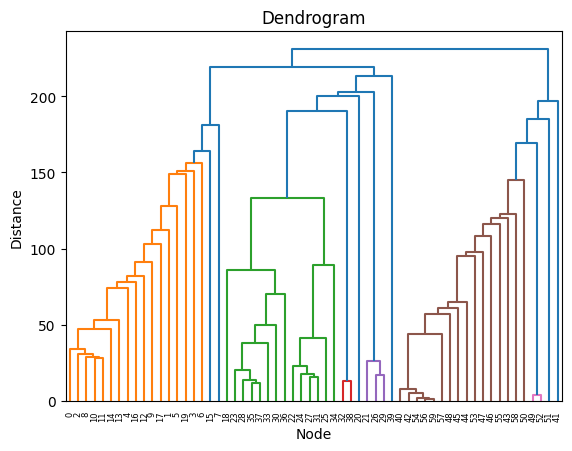

In [7]:
from dendrogram_handler_v2 import DendrogramHandler
from scipy.cluster.hierarchy import dendrogram # type: ignore
from typing import Literal

HeightMetric = Literal["distance", "max_cluster"]

def show_dendrogram(G: nx.Graph,
                    title: str = "Dendrogram",
                    height_metric: HeightMetric = "distance") -> None:
    plt.figure()
    myHandler: DendrogramHandler = DendrogramHandler(G, height_metric=height_metric)
    Z = myHandler.link_matrix       # Python style guides suggest direct access of public class variables
    ZLabels = myHandler.link_matrix_labels
    dendrogram(Z, labels=ZLabels)
    plt.title(title)
    plt.xlabel("Node")
    if height_metric == "max_cluster":
        plt.ylabel("Max Cluster Size")
    else:
        plt.ylabel("Distance")
    del myHandler

show_dendrogram(G)

Let's talk about what we are seeing. First, note that the labels on the x-axis correspond to vertices in the linegraph.

Second, let's look at all the possible partitions that can be produced when we run the Girvan-Newman algorithm. I'm going to call the sets in a partition a _group_, and define my own type for groups.


In [67]:
from typing import Set
Group = Set[Hashable]
all_partitions: list[Tuple[Group, ...]] = list(nx.algorithms.community.centrality.girvan_newman(G))
for i, partition in enumerate(all_partitions):
    print(f"partition {i} has sets {partition}")

partition 0 has sets ({0, 1}, {2, 3, 4})
partition 1 has sets ({0, 1}, {2}, {3, 4})
partition 2 has sets ({0}, {1}, {2}, {3, 4})
partition 3 has sets ({0}, {1}, {2}, {3}, {4})


#### Girvan-Newman Decomposes Vertices into a Sequence of Partitions

Recall that the Girvan-Newman algorithm finds partitions by removing the iteratively computing edge betweenness and removing the edge with highest betweenness. Partition 0 is a tuple containing two sets
- {0, 1}
- {2, 3, 4}

These disjoint sets are formed when the edge between vertex 1 and vertex 2 is removed because that edge has the highest edge betweenness.

Partition 1 is a tuple containing three sets
- {0, 1}
- {2}
- {3, 4}

These mutually disjoint sets are formed when the edge between vertex 2 and vertex 3 is removed because that edge has the highest edge betweenness.

The next partition is formed when the edge between vertex 0 and vertex 1 is removed, and final partition is formed when the edge between vertex 3 and vertex 4 is removed.

The sequence of partitions that are formed by the Girvan-Newman Partitioning algorithm are
- Partition 0
  - {0,1,2,3,4}
- Partition 1
  - {0,1}, {2,3,4}
- Partition 2
  - {0,1}, {2}, {3,4}
- Partition 3
  - {0}, {1}, {2}, {3,4}
- Partition 4
  - {0}, {1}, {2}, {3}, {4}

#### The Dendrogram Reverses the Decomposition

Dendrograms are used to represent hierarchical ways of decomposing sets. In our case, we are interested in using a dendrogram to represent how the Girvan-Newman algorithm splits the vertices of a graph into a series of partitions. Let's look at the dendrogram and then talk about how it relates to the the sequence of partitions. 



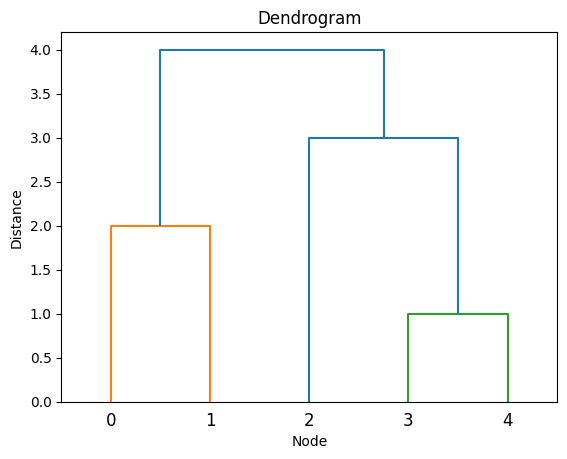

In [68]:
show_dendrogram(G)

Observe that vertices 3 and 4 are put into the same set when we reconstruct Partition 3 from Partition 4. 
- Partition 3
  - {0}, {1}, {2}, **{3,4}**
- Partition 4
  - {0}, {1}, {2}, **{3}, {4}**

Because vertex 3 and 4 are the first to be put back together, they are right next to each other on the x axis. The height of 1 on the y-axis indicates that these are the first two vertices clustered together.

Similarly, observe that vertices 0 and 1 are put into the same set when we reconstruct Partition 2 from Partition 3.
- Partition 2
  - **{0,1}**, {2}, {3,4}
- Partition 3
  - **{0}, {1}**, {2}, {3,4}

Because vertices 0 and 1 are the second pair to be put back together, they are right next to each other on the x-axis. The height of 2 on the y-axis indicates that these are the second pair of vertices clustered together.

Next, observe that vertex 2 joins the cluster {3,4} when we reconstruct Partition 1 from Partition 2.
- Partition 1
  - {0,1}, **{2,3,4}**
- Partition 2
  - {0,1}, **{2}, {3,4}**

Because vertex 2 joins the cluster {3,4} in the third merge, vertex 2 is positioned next to vertices 3 and 4 on the x-axis. The height of 3 on the y-axis indicates this is the third clustering operation.

Finally, observe that the cluster {0,1} joins the cluster {2,3,4} when we reconstruct Partition 0 from Partition 1.
- Partition 0
  - **{0,1,2,3,4}**
- Partition 1
  - **{0,1}, {2,3,4}**

The height of 4 on the y-axis indicates this is the fourth and final merge, bringing all vertices together into a single cluster. This appears at the top of the dendrogram, showing that the two major groups {0,1} and {2,3,4} are the last to be combined.



#### A Different Height Metric

Think of the height as "the number of edges yet to remove" plus 1. 

That height can sometimes make it difficult to see structures. Let's show the dendrogam but with a different height, namely, the number of nodes in the largest cluster. 


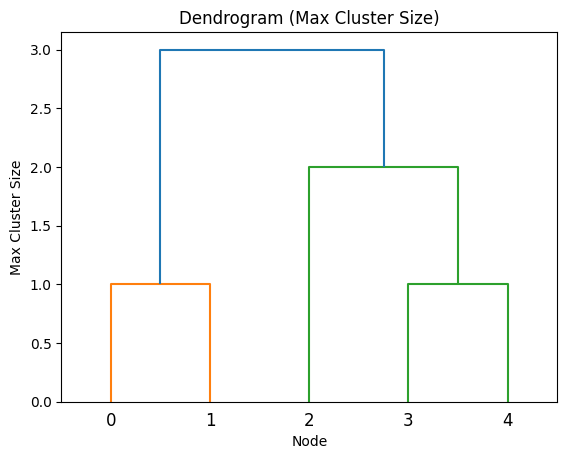

In [69]:
# Show dendrogram with max_cluster height metric
show_dendrogram(G, title="Dendrogram (Max Cluster Size)", height_metric="max_cluster")

---

#### Dendrogram for Stochastic Block Graph


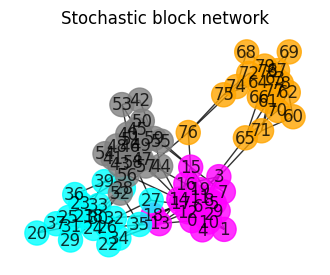

In [70]:
# Dendrogram for stochastic block model with four clear groups
sizes = [20, 20, 20, 20]
probs = [[0.25, 0.01, 0.01, 0.01], 
         [0.01, 0.25, 0.01, 0.01], 
         [0.01, 0.01, 0.25, 0.01], 
         [0.01, 0.01, 0.01, 0.25]]
G = nx.stochastic_block_model(sizes, probs, seed=42)

# Plot graph with different colors for nodes in different groups
node_colors = []
for node in G.nodes():
    if node < 20:
        node_colors.append('magenta')
    elif node < 40:
        node_colors.append('cyan')
    elif node < 60:
        node_colors.append('gray')
    else:
        node_colors.append('orange')   
_ = show_graph(G, title = "Stochastic block network", node_color=node_colors, plot_style="SPRING")

Show dendrogram

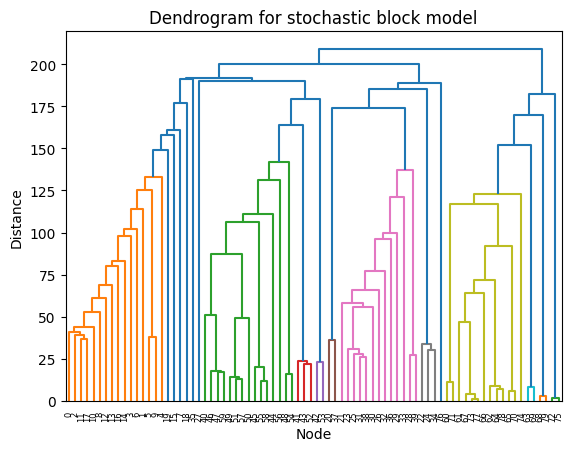

In [71]:
show_dendrogram(G, title="Dendrogram for stochastic block model")

I think it's difficult to see the patterns in this dendrogram, so let's switch to the max cluster size instead.

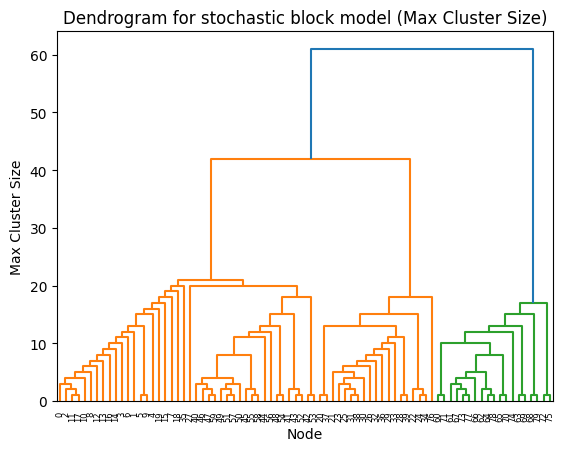

In [72]:
# show dendrogram with max_cluster height metric
show_dendrogram(G, title="Dendrogram for stochastic block model (Max Cluster Size)", height_metric="max_cluster") 

## Dendrogram for the Karate Class Network

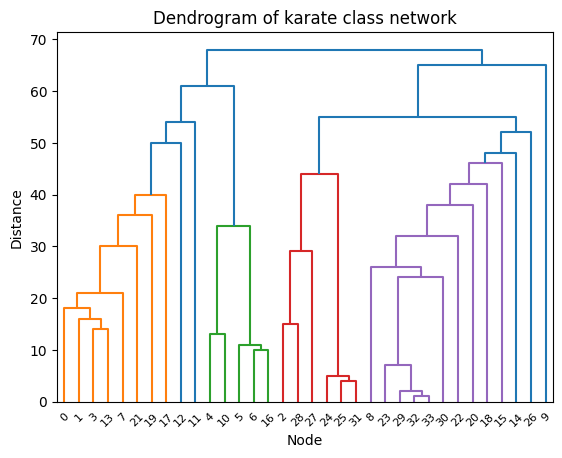

In [73]:
karate_class = nx.karate_club_graph()
show_dendrogram(karate_class, 
                title = "Dendrogram of karate class network")

The topmost part of the dendrogram shows that the vertices are separated into two disjoint sets. Let's check.

In [74]:
print(f"First group in first partition = \n\t{partition_list[0][0]}")
print(f"Second group in first partition = \n\t{partition_list[0][1]}")


First group in first partition = 
	{0, 1, 3, 4, 5, 6, 7, 10, 11, 12, 13, 16, 17, 19, 21}
Second group in first partition = 
	{2, 8, 9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33}


That list of nodes matches up with the labels on the x-axis. 

Let's look at the next partition. The second partition is where vertex 9 gets "carved off" into its own group.

In [75]:
print(f"First group in second partition = \n\t{partition_list[1][0]}")
print(f"Second group in second partition = \n\t{partition_list[1][1]}")
print(f"Third group in second partition = \n\t{partition_list[1][2]}")


First group in second partition = 
	{0, 1, 3, 4, 5, 6, 7, 10, 11, 12, 13, 16, 17, 19, 21}
Second group in second partition = 
	{32, 33, 2, 8, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31}
Third group in second partition = 
	{9}


Let's repeat one more time so that we can see the groups after we split the vertices into four groups.

In [76]:
print(f"First group in third partition = \n\t{partition_list[2][0]}")
print(f"Second group in third partition = \n\t{partition_list[2][1]}")
print(f"Third group in third partition = \n\t{partition_list[2][2]}")
print(f"Fourth group in third partition = \n\t{partition_list[2][3]}")

First group in third partition = 
	{0, 1, 3, 7, 11, 12, 13, 17, 19, 21}
Second group in third partition = 
	{32, 33, 2, 8, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31}
Third group in third partition = 
	{4, 5, 6, 10, 16}
Fourth group in third partition = 
	{9}


This split leads to an important subtlety about the dendrogram. We can use the dendrogram to help us divide a network into groups by drawing a horizontal line across it. 


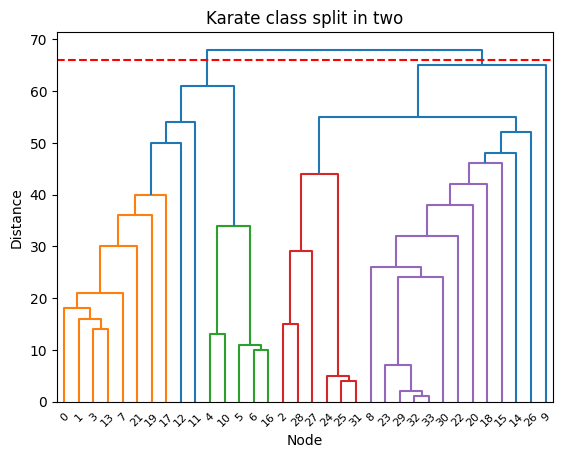

In [77]:
show_dendrogram(karate_class,
                title = "Karate class split in two")
_ = plt.axhline(y=66, color='r', linestyle='--')

Cutting the vertical lines at this point neatly divides the vertices into the first and second partitions. Let's repeat but with the line moved down.

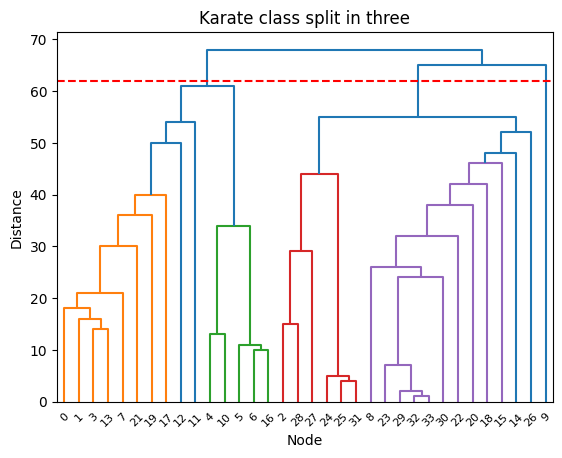

In [78]:
show_dendrogram(karate_class,
                title = "Karate class split in three")
_ = plt.axhline(y=62, color='r', linestyle='--')

This horizontal line splits the leftmost group into two, carving off node 9 into its own set. We can represent this by coloring the nodes like we did above.

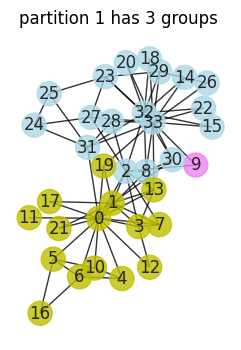

In [79]:
node_group_dict: dict[int, int] = {node: 0 for node in sorted(karate_class.nodes())}
for group_num in range(len(partition_list[1])):
    for node in partition_list[1][group_num]:
        node_group_dict[node] = group_num

node_colors = [colors[node_group_dict[node]%len(colors)] for node in karate_class.nodes()]
title: str = f"partition {1} "
title = title + f"has {len(partition_list[1])} groups "
_ = show_graph(karate_class, 
                node_color=node_colors,
                title = title)

Let's move the horizontal line down a bit and see what happens.

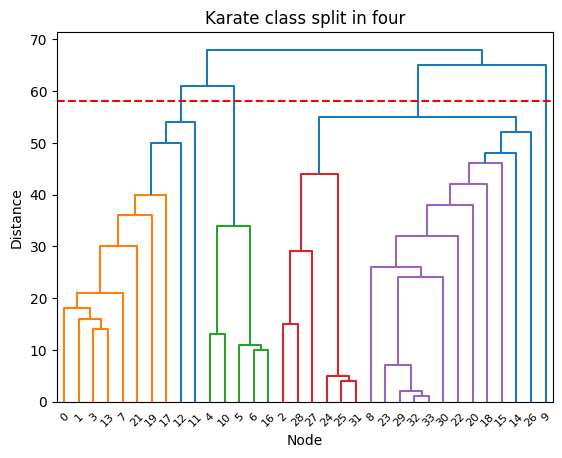

In [80]:
show_dendrogram(karate_class,
                title = "Karate class split in four")
_ = plt.axhline(y=58, color='r', linestyle='--')

We should now have four groups: 
- _First group_ = {0, 1, 3, 4, 5, 6, 7, 10, 11, 12, 13, 16, 17, 19, 21}
- _Second group_ = {4, 10, 5, 6, 16}
- _Third group_ = {2, 28, 27, 24, 25, 31, 8, 23, 29, 32, 33, 30, 22, 20, 18, 15, 14, 26}
- _Fourth group_ = {9}

Let's color the nodes and see if this is correct.


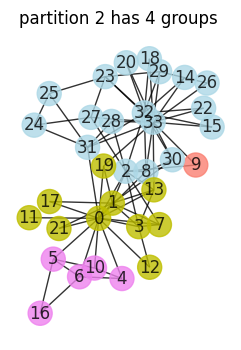

In [81]:
node_group_dict: dict[int, int] = {node: 0 for node in sorted(karate_class.nodes())}
for group_num in range(len(partition_list[2])):
    for node in partition_list[2][group_num]:
        node_group_dict[node] = group_num

node_colors = [colors[node_group_dict[node]%len(colors)] for node in karate_class.nodes()]
title: str = f"partition {2} "
title = title + f"has {len(partition_list[2])} groups "
_ = show_graph(karate_class, 
                node_color=node_colors,
                title = title)

Yep, it worked.

Show the karate club graph with other dendrogram height

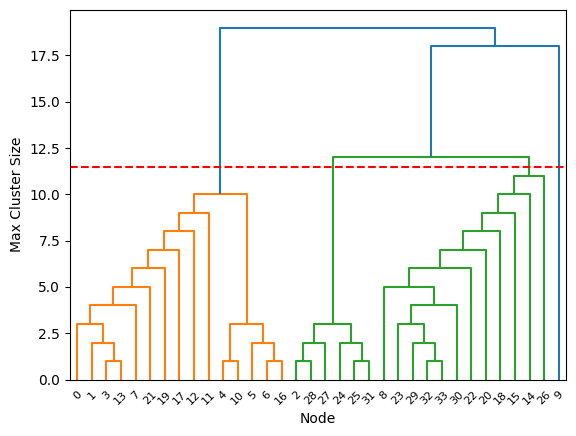

In [82]:
show_dendrogram(karate_class, title="", height_metric="max_cluster")
_ = plt.axhline(y=11.5, color='r', linestyle='--')

---
---

## Homework Problems 9 - 11

The following problems use a network that has natural communities and gives code that finds the partition that maximizes modularity. You'll use the dendrogram to build insight into what we mean when we say "natural communities".

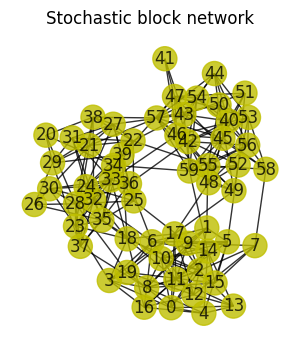

In [8]:
sizes = [20, 20, 20]
probs = [[0.35, 0.02, 0.02], [0.02, 0.35, 0.02], [0.02, 0.02, 0.40]]
G = nx.stochastic_block_model(sizes, probs, seed=42)
_ = show_graph(G, title = "Stochastic block network")

**Problem 9** Which partition does the plot of the network suggest will have the highest modularity? Why?

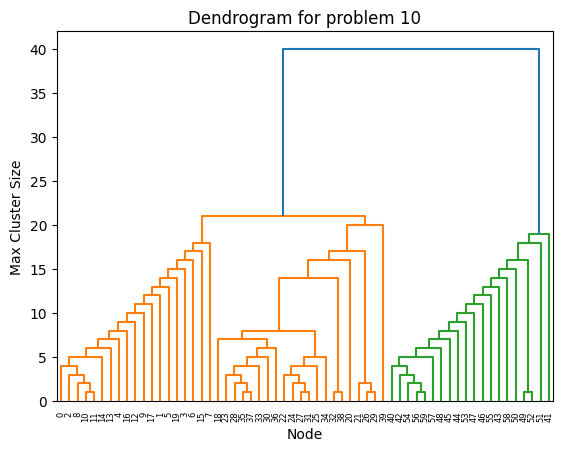

In [9]:
show_dendrogram(G, title = "Dendrogram for problem 10", height_metric="max_cluster")

**Problem 10** Which partition does the dendrogram suggest will have maximum modularity? Why?

**Problem 11** What is the modularity of the partition with highest modularity? How does the partition with highest modularity relate to the partitions you guessed when you looked at the network and the dendrogram?

In [17]:
colors: list[str] = ['y', 'lightblue', 'violet', 'salmon', 
                         'aquamarine', 'lightpink', 'lightgray', 'linen']

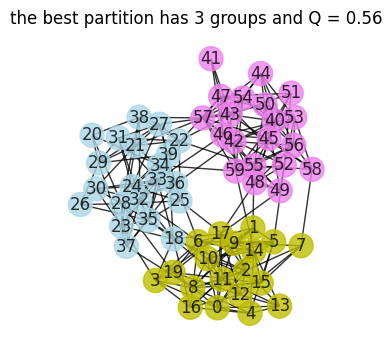

In [18]:
partitions: Iterator = nx.community.girvan_newman(G)
partition_list: list[Tuple[set, ]] = list(partitions)

best_partition = max(partition_list, 
                     key=lambda partition: nx.community.modularity(G, partition))
for i in range(len(partition_list)):
    if partition_list[i] == best_partition:
        break

# Calculate the maximum Q value for reference
max_Q = nx.community.modularity(G, best_partition)

node_group_dict: dict[int, int] = {node: 0 for node in sorted(G.nodes())}
for group_num in range(len(partition_list[i])):
    for node in partition_list[i][group_num]:
        node_group_dict[node] = group_num

node_colors = [colors[node_group_dict[node]%len(colors)] for node in G.nodes()]
title: str = f"the best partition has {len(best_partition)} groups "
title = title + f"and Q = {np.round(max_Q,2)}"
_ = show_graph(G, 
                node_color=node_colors, 
                title = title)

In [19]:
print(max_Q)

0.5563931695127031


---
---

#### Homework Problems 12 - 14

These problems use a network that has communities that aren't as obvious when we plot the network but that still has structure when we look at the dendrogram.

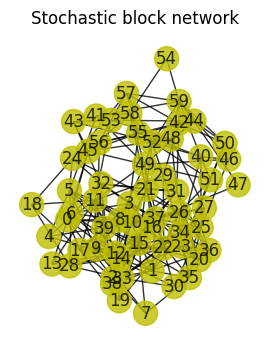

In [20]:
sizes = [20, 20, 20]
probs = [[0.25, 0.1, 0.02], [0.1, 0.25, 0.02], [0.02, 0.02, 0.25]]
G = nx.stochastic_block_model(sizes, probs, seed=42)
_ = show_graph(G, title = "Stochastic block network")

**Problem 12** Which partition does the plot of the network suggest will have the highest modularity? Why?

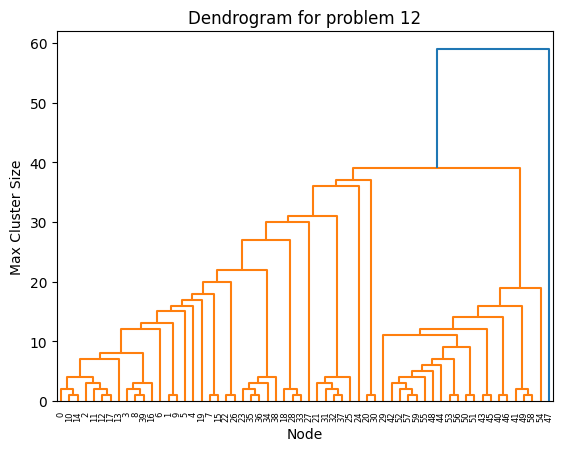

In [21]:
show_dendrogram(G, title = "Dendrogram for problem 12", height_metric="max_cluster")

**Problem 13** Which partition does the dendrogram suggest will have maximum modularity? Why?

**Problem 14** What is the modularity of the partition with highest modularity? How does the partition with highest modularity relate to the partitions you guessed when you looked at the network and the dendrogram?

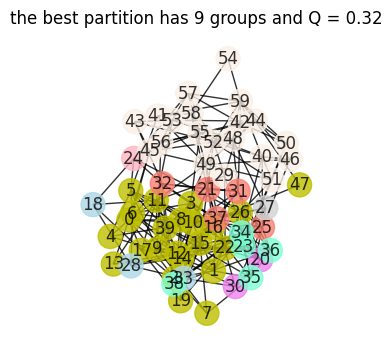

In [22]:
partitions: Iterator = nx.community.girvan_newman(G)
partition_list: list[Tuple[set, ]] = list(partitions)

best_partition = max(partition_list, 
                     key=lambda partition: nx.community.modularity(G, partition))
for i in range(len(partition_list)):
    if partition_list[i] == best_partition:
        break

# Calculate the maximum Q value for reference
max_Q = nx.community.modularity(G, best_partition)

node_group_dict: dict[int, int] = {node: 0 for node in sorted(G.nodes())}
for group_num in range(len(partition_list[i])):
    for node in partition_list[i][group_num]:
        node_group_dict[node] = group_num

node_colors = [colors[node_group_dict[node]%len(colors)] for node in G.nodes()]
title: str = f"the best partition has {len(best_partition)} groups "
title = title + f"and Q = {np.round(max_Q,2)}"
_ = show_graph(G, 
                node_color=node_colors, 
                title = title)

---
---

#### Homework Problems 15-17

Create a small-world network and explore partitioning.

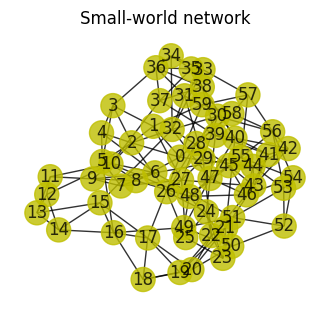

In [25]:
G = nx.newman_watts_strogatz_graph(60, 4, 0.3, seed = 42)
_ = show_graph(G, title = "Small-world network", plot_style="SPRING")

**Problem 3.a** Which partition does the plot of the network suggest will have the highest modularity? Why?

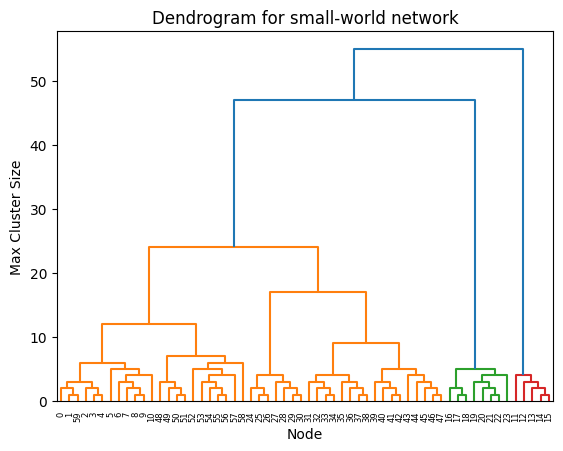

In [26]:
show_dendrogram(G, title = "Dendrogram for small-world network", height_metric="max_cluster")

**Problem 16** Which partition does the dendrogram suggest will have maximum modularity? Why?

**Problem 17** What is the modularity of the partition with highest modularity? How does the partition with highest modularity relate to the partitions you guessed when you looked at the network and the dendrogram?

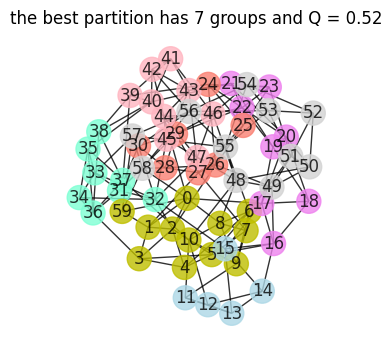

In [27]:
partitions: Iterator = nx.community.girvan_newman(G)
partition_list: list[Tuple[set, ]] = list(partitions)

best_partition = max(partition_list, 
                     key=lambda partition: nx.community.modularity(G, partition))
for i in range(len(partition_list)):
    if partition_list[i] == best_partition:
        break

# Calculate the maximum Q value for reference
max_Q = nx.community.modularity(G, best_partition)

node_group_dict: dict[int, int] = {node: 0 for node in sorted(G.nodes())}
for group_num in range(len(partition_list[i])):
    for node in partition_list[i][group_num]:
        node_group_dict[node] = group_num

node_colors = [colors[node_group_dict[node]%len(colors)] for node in G.nodes()]
title: str = f"the best partition has {len(best_partition)} groups "
title = title + f"and Q = {np.round(max_Q,2)}"
_ = show_graph(G, 
                node_color=node_colors, 
                title = title)